In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Define the directory where models will be saved
models_dir = r"C:\Users\menah\Downloads\Heart_Disease_Project\data"

model_path = os.path.join(models_dir, 'X_train_pca.csv')
X_train= pd.read_csv(model_path)

model_path = os.path.join(models_dir, 'X_test_pca.csv')
X_test=pd.read_csv(model_path) 

model_path = os.path.join(models_dir, 'heart_disease_target_test.csv')
y_test=pd.read_csv(model_path) 

model_path = os.path.join(models_dir, 'heart_disease_target_train.csv')
y_train=pd.read_csv(model_path)

In [15]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)

xgb_params = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_grid = GridSearchCV(
    estimator=xgb,
    param_grid=xgb_params,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=2
)

xgb_grid.fit(X_train, y_train)

print("Best XGB Params:", xgb_grid.best_params_)
print("Best XGB F1 Score:", xgb_grid.best_score_)


Fitting 5 folds for each of 576 candidates, totalling 2880 fits


c:\Users\menah\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:10:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGB Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500, 'subsample': 0.8}
Best XGB F1 Score: 0.8513342801022168


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Base model
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Parameter grid (start broad, then narrow down like you did earlier)
rf_params = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Stratified CV
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid search (optimize for F1)
rf_grid = GridSearchCV(
    estimator=rf,
    param_grid=rf_params,
    scoring='f1',   # ✅ focus on F1
    cv=cv_strategy,
    n_jobs=-1,
    verbose=2
)

# Fit
rf_grid.fit(X_train, y_train)

print("Best RF Params:", rf_grid.best_params_)
print("Best RF F1 Score:", rf_grid.best_score_)


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


c:\Users\menah\anaconda3\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best RF Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best RF F1 Score: 0.8155256809016105


In [17]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Parameter grid
svm_params = {
    "C": [0.1, 1, 10, 50, 100],          # regularization strength
    "kernel": ["linear", "rbf", "poly"], # kernel types
    "gamma": ["scale", "auto", 0.01, 0.1, 1]  # kernel coefficient (for rbf/poly)
}

# Grid search
svm_grid = GridSearchCV(
    SVC(probability=True, class_weight="balanced", random_state=42),
    param_grid=svm_params,
    scoring="f1",
    cv=cv_strategy,
    verbose=2,
    n_jobs=-1
)

# Fit
svm_grid.fit(X_train, y_train)

print("Best SVM Params:", svm_grid.best_params_)
print("Best SVM F1 Score:", svm_grid.best_score_)


Fitting 5 folds for each of 75 candidates, totalling 375 fits
Best SVM Params: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
Best SVM F1 Score: 0.8076118686814036


c:\Users\menah\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Cross-validation
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Parameter grid

log_params = [
    # L1 penalty: liblinear or saga
    {'penalty': ['l1'], 'solver': ['liblinear', 'saga'], 'C': [0.1, 1, 10], 'max_iter': [1000]},
    
    # L2 penalty: all solvers except saga-specific elasticnet
    {'penalty': ['l2'], 'solver': ['lbfgs', 'liblinear', 'newton-cg', 'saga'], 'C': [0.1, 1, 10], 'max_iter': [1000]},
    
    # ElasticNet: only saga, must set l1_ratio
    {'penalty': ['elasticnet'], 'solver': ['saga'], 'l1_ratio': [0.2, 0.5, 0.8], 'C': [0.1, 1, 10], 'max_iter': [1000]},
    
    # No penalty: lbfgs, newton-cg, saga
    {'penalty': ['none'], 'solver': ['lbfgs', 'newton-cg', 'saga'], 'max_iter': [1000]}
]

# Grid search
log_reg_grid = GridSearchCV(
    LogisticRegression(class_weight="balanced", max_iter=5000, random_state=42),
    param_grid=log_params,
    scoring="f1",
    cv=cv_strategy,
    verbose=2,
    n_jobs=-1
)

# Fit
log_reg_grid.fit(X_train, y_train)

print("Best Logistic Regression Params:", log_reg_grid.best_params_)
print("Best Logistic Regression F1 Score:", log_reg_grid.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Logistic Regression Params: {'C': 0.1, 'l1_ratio': 0.5, 'max_iter': 1000, 'penalty': 'elasticnet', 'solver': 'saga'}
Best Logistic Regression F1 Score: 0.8276778832896122


c:\Users\menah\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\menah\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\menah\anaconda3\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\menah\anaconda3\Lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\menah\anaconda3\Lib\site-packages\

In [19]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

dt_params = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [None, 3, 5, 10, 20, 30],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 8],
    "max_features": [None, "sqrt", "log2"]
}

dt_grid = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    param_grid=dt_params,
    scoring="f1",
    cv=cv_strategy,
    verbose=2,
    n_jobs=-1
)

dt_grid.fit(X_train, y_train)

print("Best Decision Tree Params:", dt_grid.best_params_)
print("Best Decision Tree F1 Score:", dt_grid.best_score_)


Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Best Decision Tree Params: {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 20}
Best Decision Tree F1 Score: 0.8137963874748101


In [20]:
# Dictionary to store best params from your searches
best_params = {
    "RandomForest": rf_grid.best_params_,
    "SVM": svm_grid.best_params_,
    "LogisticRegression": log_reg_grid.best_params_,
    "DecisionTree": dt_grid.best_params_,
    "XGB": xgb_grid.best_params_   
}

In [21]:
final_models = {
    "RandomForest": RandomForestClassifier(**best_params["RandomForest"], random_state=42, class_weight="balanced"),
    "SVM": SVC(**best_params["SVM"], probability=True, random_state=42),
    "LogisticRegression": LogisticRegression(**best_params["LogisticRegression"], random_state=42),
    "DecisionTree": DecisionTreeClassifier(**best_params["DecisionTree"], random_state=42, class_weight="balanced"),
    "XGB": XGBClassifier(**best_params["XGB"], use_label_encoder=False, eval_metric="logloss", random_state=42)
}

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

results_final = []

for name, model in final_models.items():
    model.fit(X_train, y_train)  # fit on full training set
    
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    
    results_final.append([name, acc, prec, rec, f1, auc])

# Save in DataFrame
results_final_df = pd.DataFrame(results_final, columns=["Model", "Accuracy", "Precision", "Recall", "F1-score", "AUC"])
results_final_df = results_final_df.sort_values(by="F1-score", ascending=False).round(3)

print(results_final_df)

c:\Users\menah\anaconda3\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\menah\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\menah\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\menah\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:11:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } ar

                Model  Accuracy  Precision  Recall  F1-score    AUC
0        RandomForest     0.933      0.955   0.875     0.913  0.941
1                 SVM     0.900      0.909   0.833     0.870  0.928
2  LogisticRegression     0.900      0.909   0.833     0.870  0.925
3        DecisionTree     0.867      0.767   0.958     0.852  0.939
4                 XGB     0.850      0.826   0.792     0.809  0.913


In [40]:
# Save DataFrame to txt (tabular text)
with open(r"C:\Users\menah\Downloads\Heart_Disease_Project\results\evaluation_metrics.txt", "a") as f:
    f.write('After Hyperparameter Tuning\n')
    f.write(results_final_df.to_string(index=False))

In [22]:
from sklearn.metrics import roc_curve

roc_curves = {}

for name, model in final_models.items():
    model.fit(X_train, y_train)
    
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]  # prob for class 1
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_curves[name] = (fpr, tpr)

c:\Users\menah\anaconda3\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\menah\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\menah\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\menah\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:11:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } ar

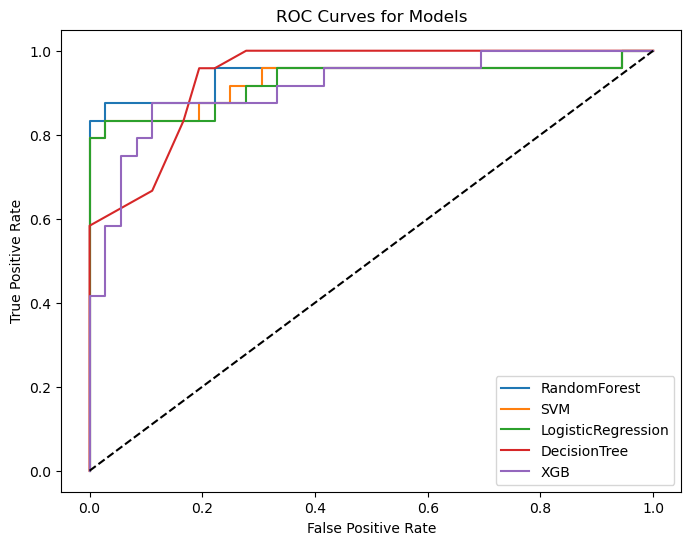

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
for name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=name)

plt.plot([0,1], [0,1], 'k--')  # diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Models")
plt.legend()
plt.show()

### Best performing models

-Supervised Learning: Random Forest  is the stronger performer overall

-Supervised Learning (optimized hyperparameters): Random Forest  is the stronger performer overall

In [24]:
import joblib
import os

# Define the directory where models will be saved
models_dir = r"C:\Users\menah\Downloads\Heart_Disease_Project\models"
os.makedirs(models_dir, exist_ok=True)  # Create directory if it doesn't exist


# Save all supervised models

for name, model in final_models.items():
    model_path = os.path.join(models_dir, f"{name}_best_model.pkl")
    joblib.dump(model, model_path)
    print(f"Saved {name} to {model_path}")

Saved RandomForest to C:\Users\menah\Downloads\Heart_Disease_Project\models\RandomForest_best_model.pkl
Saved SVM to C:\Users\menah\Downloads\Heart_Disease_Project\models\SVM_best_model.pkl
Saved LogisticRegression to C:\Users\menah\Downloads\Heart_Disease_Project\models\LogisticRegression_best_model.pkl
Saved DecisionTree to C:\Users\menah\Downloads\Heart_Disease_Project\models\DecisionTree_best_model.pkl
Saved XGB to C:\Users\menah\Downloads\Heart_Disease_Project\models\XGB_best_model.pkl


In [37]:
# 07_final_pipeline.ipynb

# ==== 1. Imports ====
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
import joblib
import os

# ==== 2. Load your data ====
# Replace with your actual dataset path
df = pd.read_csv(r"C:\Users\menah\Downloads\Heart_Disease_Project\data\heart_disease.csv")
df.columns = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
    "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"
]

# Define target and features
target_col = "target"
X = df.drop(columns=[target_col])
y = df[target_col]

# ==== 3. Column selection ====
cat_columns = X.select_dtypes(include="object").columns
num_columns = X.select_dtypes(include=[np.number]).columns

In [38]:
# ==== 4. Preprocessor ====
from sklearn.impute import SimpleImputer
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", num_transformer, num_columns),
    ("cat", cat_transformer, cat_columns)
])

In [39]:
# ==== 5. Build Classification Pipeline ====
optimal_components = 18   # retain 95% variance
n_features_to_select = 18

clf_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("pca", PCA(n_components=optimal_components)),
    ("classifier", RandomForestClassifier(
        random_state=42,
        class_weight="balanced",
        n_estimators=300,
        max_depth=10,
        max_features="sqrt",
        min_samples_leaf=4,
        min_samples_split=2
    ))
])

# ==== 6. Fit classification pipeline ====
clf_pipeline.fit(X, y)

# ==== 7. Save classification pipeline ====
models_dir = r"C:\Users\menah\Downloads\Heart_Disease_Project\models"
os.makedirs(models_dir, exist_ok=True)

clf_path = os.path.join(models_dir, "RandomForest_full_pipeline.pkl")
joblib.dump(clf_pipeline, clf_path)
print(f"✅ Classification pipeline saved at {clf_path}")




✅ Classification pipeline saved at C:\Users\menah\Downloads\Heart_Disease_Project\models\RandomForest_full_pipeline.pkl
